In [1]:
import pandas as pd
import sqlalchemy
from matplotlib import pyplot as plt
import datetime
import copy
import numpy as np
pd.options.mode.chained_assignment = None

In [2]:
db = sqlalchemy.engine.url.URL(drivername='mysql',
                            host='127.0.0.1',
                            database='sherman_1',
                            query={'read_default_file': '~/.my.cnf', 'charset':'utf8'})
engine = sqlalchemy.create_engine(db)

In [3]:
df = pd.read_sql('''
    SELECT * FROM sherman_1.calls;
''' ,engine)

In [4]:
print(df['device_id'].nunique())
df_id = pd.read_csv('/home/memari/jhu_centering/tables/id.csv')
# second device_id
l = [17,18,61,20,22,37]
l2 = set()
for index in l:
    l2.add(df_id.loc[index,'device_id2'])
# create a dict of 'device_id2':'device_id1'
my_dict = {}
for index, row in df_id.iterrows():
    if row['device_id2'] in l2:
        my_dict[row['device_id2']] = row['device_id1']
# replace
for index, row in df.iterrows():
    if row['device_id'] in my_dict:
        df.loc[index,'device_id'] = my_dict[row['device_id']]
print(df['device_id'].nunique())

86
82


In [5]:
def get_incoming_outgoing_missed(df):
    uniq_device_id = list(set(df['device_id'].tolist()))
    df_output = pd.DataFrame()
    df_incoming = pd.DataFrame()
    df_outgoing = pd.DataFrame()
    df_missed = pd.DataFrame()
    for device_id in uniq_device_id:
        df_target = df[df['device_id']==device_id]
        df_target = df_target.sort_values(by = 'timestamp', ascending = False)
        
        df_output_temp = df_target[['device_id','timestamp']]
        
        past_type = df_target['call_type'].tolist()
        past_type = past_type[1:]+[None]
        future_type = df_target['call_type'].tolist()
        future_type = [None]+future_type[:-1]
        duration = df_target['call_duration'].tolist()
        duration = [None]+duration[:-1]
        
        df_target['past_type'] = past_type
        df_target['future_type'] = future_type
        df_target['duration'] = duration
        
        

        #incoming
        df_incoming_temp = df_target[(df_target['past_type']==1)&
                                   (df_target['call_type']==2)&
                                   (df_target['future_type']==4)]
        
        df_incoming_temp['incoming_time'] = df_incoming_temp['duration']
        df_incoming_temp = df_incoming_temp[['device_id','timestamp','incoming_time']]
        
        
        #outgoing
        df_outgoing_temp = df_target[(df_target['past_type']==3)&
                                   (df_target['call_type']==2)&
                                   (df_target['future_type']==4)]
        
        df_outgoing_temp['outgoing_time'] = df_outgoing_temp['duration']
        df_outgoing_temp = df_outgoing_temp[['device_id','timestamp','outgoing_time']]
        
        
        #missing
        df_missing_temp = df_target[(df_target['call_type']==4)&
                                   (df_target['past_type']!=2)]
        
        df_missing_temp['missing_time'] = df_missing_temp['duration']
        df_missing_temp = df_missing_temp[['device_id','timestamp','missing_time']]
        
        df_output_temp = df_output_temp.merge(df_incoming_temp, on = ['device_id','timestamp'], how = 'left')
        df_output_temp = df_output_temp.fillna(0)
        
        df_output_temp = df_output_temp.merge(df_outgoing_temp, on = ['device_id','timestamp'], how = 'left')
        df_output_temp = df_output_temp.fillna(0)
        
        df_output_temp = df_output_temp.merge(df_missing_temp, on = ['device_id','timestamp'], how = 'left')
        df_output_temp = df_output_temp.fillna(0)
        
        if df_output_temp.shape[0]>0:
            df_output = pd.concat([df_output, df_output_temp], ignore_index=True)
    
    return df_output

In [6]:
df_less = get_incoming_outgoing_missed(df)
df_less['date'] = pd.to_datetime(df_less['timestamp'],unit='ms').dt.date

In [7]:
df_less = df_less[['device_id','date','incoming_time','outgoing_time','missing_time']]
df_less['incoming_freq'] = df_less['incoming_time'].apply(lambda x: int(x>0))
df_less['outgoing_freq'] = df_less['outgoing_time'].apply(lambda x: int(x>0))
df_less['missing_freq'] = df_less['missing_time'].apply(lambda x: int(x>0))

In [8]:
df_output = df_less.groupby(['device_id','date']).agg(incoming_time = ('incoming_time', np.sum),
                                                      incoming_freq = ('incoming_freq',np.sum),
                                                      outgoing_time = ('outgoing_time', np.sum),
                                                      outgoing_freq = ('outgoing_freq',np.sum),
                                                      missing_time = ('missing_time', np.sum),
                                                      missing_freq = ('missing_freq',np.sum),
                                                     )
df_output = df_output.reset_index()
df_output['incoming_freq'] = df_output['incoming_freq'].apply(lambda x: int(x))
df_output['outgoing_freq'] = df_output['outgoing_freq'].apply(lambda x: int(x))
df_output['missing_freq'] = df_output['missing_freq'].apply(lambda x: int(x))
df_output

,device_id,date,incoming_time,incoming_freq,outgoing_time,outgoing_freq,missing_time,missing_freq
0,00e17b8a-4b0f-4230-bd26-3df2853e8916,2022-12-19,625.0,3,24.0,2,0.0,0
1,00e17b8a-4b0f-4230-bd26-3df2853e8916,2022-12-20,1876.0,7,1830.0,14,1176.0,2
2,00e17b8a-4b0f-4230-bd26-3df2853e8916,2022-12-21,5157.0,10,803.0,3,0.0,0
3,00e17b8a-4b0f-4230-bd26-3df2853e8916,2022-12-22,1403.0,4,335.0,16,954.0,2
4,00e17b8a-4b0f-4230-bd26-3df2853e8916,2022-12-23,4783.0,6,996.0,4,0.0,0
...,...,...,...,...,...,...,...,...
2544,ffe96eaa-8909-4958-a34e-0ed1fe68f9bd,2022-12-27,29.0,1,1285.0,5,0.0,0
2545,ffe96eaa-8909-4958-a34e-0ed1fe68f9bd,2022-12-28,0.0,0,1795.0,3,0.0,0
2546,ffe96eaa-8909-4958-a34e-0ed1fe68f9bd,2022-12-29,0.0,0,911.0,6,0.0,0
2547,ffe96eaa-8909-4958-a34e-0ed1fe68f9bd,2022-12-30,13.0,1,330.0,3,0.0,0


In [9]:
df_output.to_csv("/home/memari/jhu_centering/tables/calls_cleaned.csv", index = False)

In [10]:
# find the first day
def find_first_day(device_id, df_cleaned):
    df_target = df_cleaned[df_cleaned['device_id']==device_id]
    return min(df_target['date'])

In [17]:
def halve(df):
    first_day = {device_id:find_first_day(device_id, df) 
                 for device_id in set(df['device_id'].tolist())
                if find_first_day(device_id, df)>=datetime.date(year=2022,month=11,day=11)}
    df = df[df['device_id'].isin(first_day)]
    df['day'] = df.apply(lambda x: 1+(x['date']-first_day[x['device_id']]).days, axis = 1)
    df_1_14 = df[df['day']<=14]
    df_15_28 = df[(df['day']>14) & (df['day']<=28)]
    return df_1_14,df_15_28

In [18]:
df_1_14,df_15_28= halve(df_output)

# lineplot


In [19]:
df_plot = copy.deepcopy(df_15_28)
#df_plot = df_plot.merge(df_group[['device_id','Group']], on = 'device_id', how = 'left')
df_plot = df_plot[['day','incoming_time','outgoing_time','missing_time','incoming_freq','outgoing_freq','missing_freq']]
df_plot = df_plot.groupby('day').mean()
df_plot = df_plot.reset_index()
df_plot


,day,incoming_time,outgoing_time,missing_time,incoming_freq,outgoing_freq,missing_freq
0,15,843.981818,1387.036364,218.672727,2.509091,3.763636,0.236364
1,16,640.629630,978.703704,10.111111,2.111111,2.555556,0.092593
2,17,860.660000,973.960000,101.060000,2.320000,3.120000,0.180000
3,18,1296.076923,749.211538,8.461538,2.480769,3.153846,0.096154
4,19,653.754717,756.018868,17.018868,1.754717,2.377358,0.283019
5,20,896.796296,804.333333,262.981481,2.148148,2.648148,0.407407
6,21,842.490566,673.716981,4.924528,2.452830,2.113208,0.075472
7,22,1325.807692,779.403846,51.576923,2.288462,3.076923,0.115385
8,23,857.096154,1071.192308,234.461538,1.980769,2.788462,0.115385
9,24,583.980769,940.480769,77.326923,2.076923,3.230769,0.173077


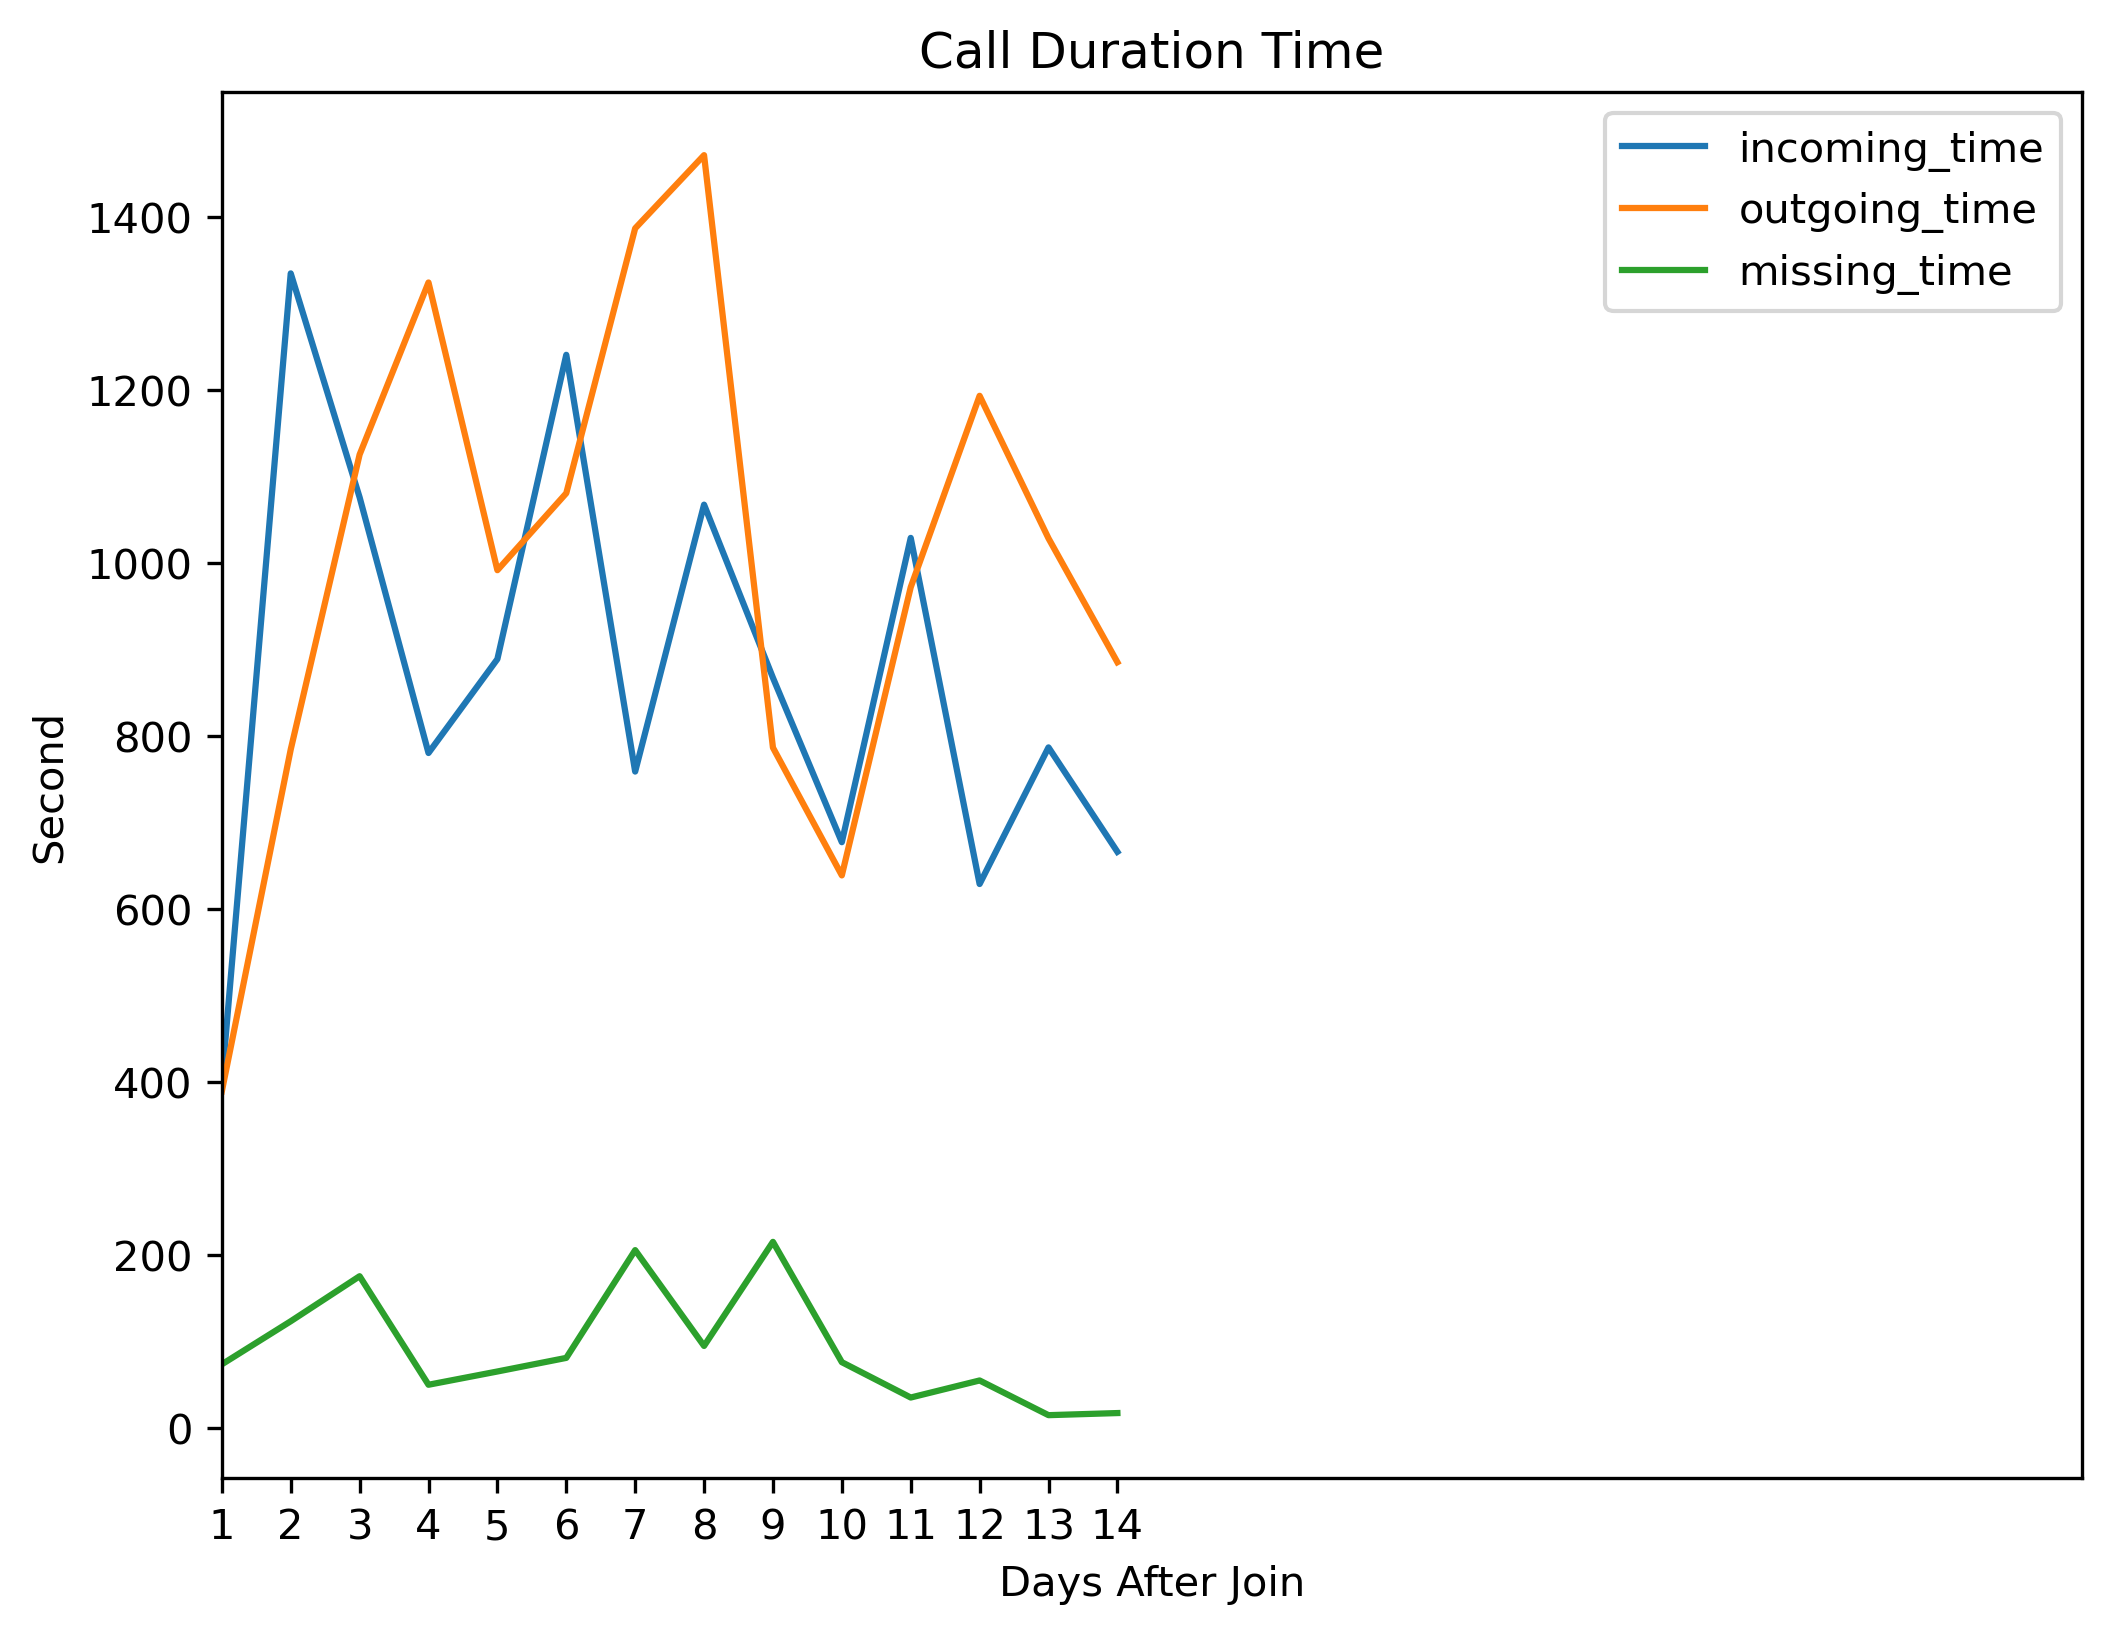

In [14]:
plt.figure(figsize=(8, 6), dpi=300)
for feature in ['incoming_time','outgoing_time','missing_time']:
    x = [i+1 for i in range(14)]
    y = df_plot[feature].tolist()
    plt.plot(x,y,label = feature)
plt.xlim(1,28)
plt.xticks([i+1 for i in range(14)],[i+1 for i in range(14)])
plt.title("Call Duration Time")
plt.xlabel("Days After Join")
plt.ylabel('Second')
plt.legend()
plt.show()

In [15]:
plt.figure(figsize=(8, 6), dpi=300)
for feature in ['incoming_freq','outgoing_freq','missing_freq']:
    x = [i+1 for i in range(28)]
    y = df_plot[feature].tolist()
    plt.plot(x,y,label = feature)
plt.xlim(1,28)
plt.xticks([i+1 for i in range(28)],[i+1 for i in range(28)])
plt.title("Call Frequency")
plt.xlabel("Days After Join")
plt.ylabel('Times')
plt.legend()
plt.show()

ValueError: x and y must have same first dimension, but have shapes (28,) and (14,)

# group plot


In [ ]:
df_id = pd.read_csv("/data/meditation/majid/tables/id.csv")
df_id = df_id.drop_duplicates('study_id')
df_id = df_id.drop('id', axis = 1)
df_id.columns = ['device_id','Study ID']
df_id



In [ ]:
df_group = pd.read_csv('/data/meditation/majid/surveys/0.csv', skiprows=[1,2])[['Study ID','Group']]
df_group = df_id.merge(df_group, on = 'Study ID', how = 'left')
df_group

In [ ]:
df_plot = copy.deepcopy(df_cleaned_1_28)
df_plot = df_plot.merge(df_group[['device_id','Group']], on = 'device_id', how = 'left')
df_plot = df_plot[['day','Group','incoming_time','outgoing_time','missing_time','incoming_freq','outgoing_freq','missing_freq']]
df_plot = df_plot.groupby(['Group','day']).mean()
df_plot = df_plot.reset_index()
df_plot


In [ ]:
for feature in ['incoming_time','outgoing_time','missing_time']:
    plt.figure(figsize=(8, 6), dpi=300)
    for group in ['Active Control', 'Experimental Condition', 'Passive Control']:
        df_target = df_plot[df_plot['Group']==group]
        x = [i+1 for i in range(28)]
        y = df_target[feature].tolist()
        plt.plot(x,y,label = group)
    plt.xlim(1,28)
    plt.xticks([i+1 for i in range(28)],[i+1 for i in range(28)])
    plt.title("Call Duration - "+feature)
    plt.xlabel("Days After Join")
    plt.ylabel('Second')
    plt.legend()
    plt.show()

In [ ]:
for feature in ['incoming_freq','outgoing_freq','missing_freq']:
    plt.figure(figsize=(8, 6), dpi=300)
    for group in ['Active Control', 'Experimental Condition', 'Passive Control']:
        df_target = df_plot[df_plot['Group']==group]
        x = [i+1 for i in range(28)]
        y = df_target[feature].tolist()
        plt.plot(x,y,label = group)
    plt.xlim(1,28)
    plt.xticks([i+1 for i in range(28)],[i+1 for i in range(28)])
    plt.title("Call Frequency - "+feature)
    plt.xlabel("Days After Join")
    plt.ylabel('Times')
    plt.legend()
    plt.show()